In [23]:
import spacy
from spacy import displacy
from lambeq.backend.drawing import draw
from lambeq.backend.grammar import Cup, Id, Ty, Word
from lambeq import AtomicType, IQPAnsatz, NumpyModel, QuantumTrainer, SPSAOptimizer, Dataset
from lambeq.training.loss import CELoss4
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
os.environ["TOKENIZERS_PARALLELISM"] = "false"
#import en_core_web_trf
n, s = Ty('n'), Ty('s')
# nlp = en_core_web_trf.load()
nlp = spacy.load("ja_ginza")

In [24]:
import csv
import csv
import numpy as np

def read_data_csv_4class_binary(filename):
    """
    CSVを読み込み、
    - ラベル0〜3だけ使用（4以上のラベル行は除外）
    - ラベルを 2×2 行列に変換
    - (labels, sentences) を返す
    """
    sentences = []
    label_list = []   # クラス番号（0〜3）

    with open(filename, encoding='utf-8') as f:
        reader = csv.reader(f)
        next(reader)   # header を飛ばす

        for row in reader:
            text = row[0].strip()
            t = int(row[1])

            # ★ 4以上はスキップ（削除）
            if t < 0 or t > 3:
                continue

            sentences.append(text)
            label_list.append(t)

    label_arr = np.array(label_list)
    N = len(idx_arr)

    # --- 2×2 行列へ変換 ---
    labels = np.zeros((N, 2, 2), dtype=float)
    labels[np.arange(N), (idx_arr // 2), (idx_arr % 2)] = 1.0

    return labels, sentences



In [25]:
import csv
import numpy as np

def read_data_csv_4class(path):
    sentences = []
    labels = []

    label_to_onehot = {
        0: np.array([[1, 0],[0, 0]], dtype=float),
        1: np.array([[0, 1], [0, 0]], dtype=float),
        2: np.array([[0, 0], [1, 0]], dtype=float),
        3: np.array([[0, 0], [0, 1]], dtype=float),
    }

    with open(path, encoding="utf-8") as f:
        reader = csv.reader(f)
        next(reader)

        for row in reader:
            text = row[0].strip()
            label = int(row[1])

            if 0 <= label <= 3:
                sentences.append(text)
                labels.append(label_to_onehot[label])

    return np.array(labels), sentences


In [26]:
train_labels, train_sentences = read_data_csv_4class('/home/hiro1/研究/data/emotion/emotion_train_final_2.csv')
dev_labels, dev_sentences = read_data_csv_4class('/home/hiro1/研究/data/emotion/emotion_validation_final_2.csv')
test_labels, test_sentences = read_data_csv_4class('/home/hiro1/研究/data/emotion/emotion_test_final_cleaned_2.csv')

In [27]:
train_labels[:5], train_sentences[:5]

(array([[[1., 0.],
         [0., 0.]],
 
        [[1., 0.],
         [0., 0.]],
 
        [[0., 0.],
         [0., 1.]],
 
        [[0., 0.],
         [1., 0.]],
 
        [[0., 0.],
         [0., 1.]]]),
 ['屈辱を感じなかった。',
  'とても絶望的な気分から、とても希望に満ちた気分になることができます',
  '貪欲さが間違っていると感じます。',
  '私はいつも暖炉のことを懐かしく感じています、それはいつかわかるでしょう',
  '不機嫌な気分です。'])

In [28]:
print(train_labels.shape)   # (N, 4)
print(len(train_sentences)) # N

(12297, 2, 2)
12297


In [29]:
def dependency_df(doc):
    
    doc = nlp(sentence)
    df = pd.DataFrame(columns=['token','token_num', 'dependency', 'token_head', 'token_head_num'])

    for token in doc:
        df = pd.concat([df, pd.DataFrame([{
            'token': token.text,
            'token_num': token.i,
            'dependency': token.dep_,
            'token_head': token.head.text,
            'token_head_num': token.head.i
        }])], ignore_index=True)
    
    
    return df

In [30]:
def dock_adjacent_by_head(df):
    """
    隣接していて token_head_num が同じ行群をまとめる。
    - df は少なくとも ['token','token_num','dependency','token_head','token_head_num'] を含むこと。
    - 位置（行順）は df の現在の順序で扱う。処理後に token_num を 0..N-1 で再付番する。
    """
    # 作業用に位置順にして index を付ける
    df = df.reset_index(drop=True).copy()
    n = len(df)
    i = 0
    groups = []  # 各グループは dict {rows: [pos0, pos1,...], orig_token_nums: [...], head_num_orig: int, head_text_orig: str}
    
    while i < n:
        head_num = int(df.loc[i, 'token_head_num'])
        group_rows = [i]
        j = i + 1
        # 連続する限り同じ head_num のものをグループにする
        while j < n and int(df.loc[j, 'token_head_num']) == head_num:
            group_rows.append(j)
            j += 1
        # 保存
        orig_token_nums = [int(df.loc[r, 'token_num']) for r in group_rows]
        groups.append({
            'rows': group_rows,
            'orig_token_nums': orig_token_nums,
            'head_num_orig': head_num,
            'head_text_orig': df.loc[i, 'token_head']  # 同じ head_num を参照しているので任意の行の token_head でよい
        })
        i = j
    
    # 各グループで token を結合。dependency はグループの最初の行の dependency を採用
    merged = []
    for g in groups:
        rows = g['rows']
        tokens = [str(df.loc[r, 'token']) for r in rows]
        merged_token = ''.join(tokens)  # 単純連結（必要ならここでスペースなどのルールを入れる）
        dependency = df.loc[rows[0], 'dependency']
        # head の参照先は groups の head_num_orig（元の token_num）なので後で新しい token_num にマップする
        merged.append({
            'token': merged_token,
            'orig_token_nums': g['orig_token_nums'],
            'dependency': dependency,
            'head_num_orig': g['head_num_orig'],
            # token_head は一旦 head の元の文字列を入れておく（後で更新）
            'token_head_orig': g['head_text_orig']
        })
    
    # 新しい token_num を付与（0..）
    for new_idx, m in enumerate(merged):
        m['token_num_new'] = new_idx
    
    # マッピング：元の token_num -> new token index & new token text
    orignum_to_newidx = {}
    orignum_to_newtoken = {}
    for m in merged:
        new_idx = m['token_num_new']
        for orig in m['orig_token_nums']:
            orignum_to_newidx[orig] = new_idx
            orignum_to_newtoken[orig] = m['token']
    
    # 最終行を作る：token_head_num, token_head を新しい値に置換
    final_rows = []
    for m in merged:
        # 元の head_num が self-reference（例えば root が自身を参照している）や
        # 他のトークンを参照している場合がある。
        head_orig = int(m['head_num_orig'])
        # もし head_orig がマッピングにあるなら新しいインデックスに変換
        if head_orig in orignum_to_newidx:
            new_head_num = orignum_to_newidx[head_orig]
            new_head_text = orignum_to_newtoken[head_orig]
        else:
            # 参照先がデータ外（稀）なら -1 を入れる or 元の値をそのまま残す（ここでは元のを採る）
            new_head_num = head_orig
            new_head_text = m['token_head_orig']
        
        final_rows.append({
            'token': m['token'],
            'token_num': m['token_num_new'],
            'dependency': m['dependency'],
            'token_head': new_head_text,
            'token_head_num': new_head_num
        })
    
    df_out = pd.DataFrame(final_rows, columns=['token','token_num','dependency','token_head','token_head_num'])
    return df_out

In [31]:
def build_pregroup_from_df(df):
    n, s = Ty('n'), Ty('s')
    cups = Id()

    # 空の Ty を入れる（ここで非参照問題はなし）
    df['type'] = [Ty() for _ in range(len(df))]

    for idx, row in df.iterrows():
        i = row['token_num']
        head_i = row['token_head_num']
        dep = row['dependency']

        # 現在の type を取り出す（コピー）
        ty = df.at[idx, 'type']

        # head の type を取り出す
        head_row = df.index[df['token_num'] == head_i][0]
        head_ty = df.at[head_row, 'type']

        # --- ROOT ---
        if dep == 'ROOT':
            new_ty = ty @ s
            df.at[idx, 'type'] = new_ty
            cups @= Id(s)
        
        # --- 非ROOT ---
        else:
            # 自分に n
            new_ty = ty @ n
            df.at[idx, 'type'] = new_ty

            # head に n.r または n.l を与える
            if i < head_i:
                new_head_ty = head_ty @ n.r
                df.at[head_row, 'type'] = new_head_ty
                cups @= Cup(n, n.r)

            elif i > head_i:
                new_head_ty = head_ty @ n.l
                df.at[head_row, 'type'] = new_head_ty
                cups @= Cup(n.l, n)

    return cups, df

In [32]:
def assign_words(df):
    Words = []
    for idx, row in df.iterrows():
        word = row['token']
        ty = row['type']
        Words.append(Word(word, ty))
    
    return Words

In [33]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib.font_manager as fm
'''
# 日本語フォントを設定
font_path = "C:\\Windows\\Fonts\\meiryo.ttc" 
jp_font = fm.FontProperties(fname=font_path) 
# matplotlibにフォントを設定
rcParams['font.family'] = jp_font.get_name()
'''


# Ubuntu のNotoフォント（日本語）
font_path = "/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc"

jp_font = fm.FontProperties(fname=font_path)

# matplotlib にフォントを設定
rcParams['font.family'] = jp_font.get_name()


# diagram作成
def create_diagram(sentence):
    doc = nlp(sentence)
    df = dependency_df(doc)
    #cleaned_df = dock_adjacent_by_head(df)
    cups, dep_with_types_df = build_pregroup_from_df(df)
    n, s = Ty('n'), Ty('s')
    types = Ty()
    
    word = assign_words(dep_with_types_df)
    
    diagram = Id().tensor(*word)
    
    for type in dep_with_types_df['type']:
        types @= type
    i = 0
    while i < len(types) - 1:
        if types[i:i + 2] == n @ n.r:  
            diagram = diagram >> types[:i] @ Cup(n, n.r) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        elif types[i:i + 2] == n.l @ n:
            diagram = diagram >> types[:i] @ Cup(n.l, n) @ types[i + 2:]
            types = types[:i] @ types[i + 2:]
            i = max(0, i - 1)
        else:
            i += 1
    
           
    return diagram

In [34]:
train_diagrams = []
dev_diagrams = []
test_diagrams = []

for i in range(len(train_sentences)):
    sentence = train_sentences[i]
    train_diagrams.append(create_diagram(sentence))
for i in range(len(dev_sentences)):
    sentence = dev_sentences[i]
    dev_diagrams.append(create_diagram(sentence))
for i in range(len(test_sentences)):
    sentence = test_sentences[i]
    test_diagrams.append(create_diagram(sentence))


=== train_diagrams[0] ===


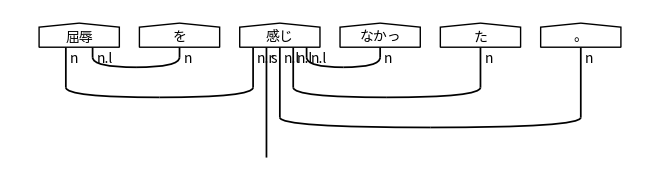

=== train_diagrams[1] ===


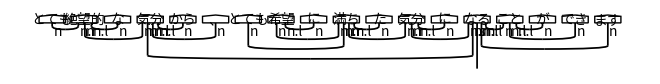

=== train_diagrams[2] ===


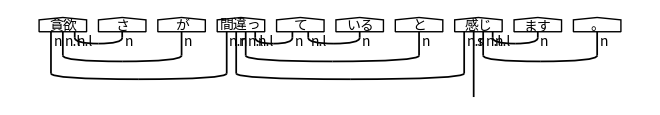

=== train_diagrams[3] ===


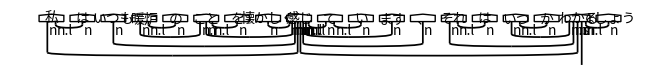

=== train_diagrams[4] ===


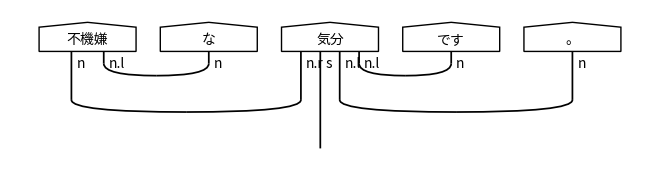

=== train_diagrams[5] ===


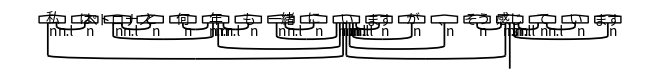

=== train_diagrams[6] ===


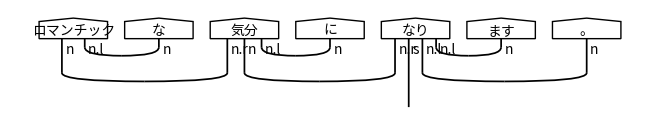

=== train_diagrams[7] ===


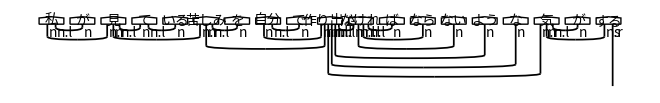

=== train_diagrams[8] ===


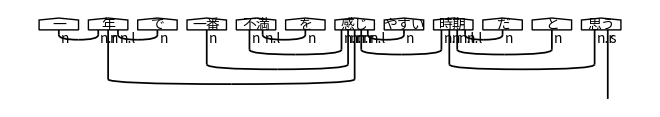

=== train_diagrams[9] ===


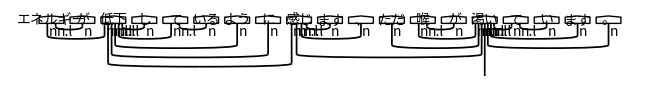

In [35]:
for i in range(min(10, len(train_diagrams))):
    print(f"=== train_diagrams[{i}] ===")
    train_diagrams[i].draw()

In [36]:
# 量子回路設計（IQPAnsatz）
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 2},
                   n_layers=1, n_single_qubit_params=3)

train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]

--- diagram 0 ---


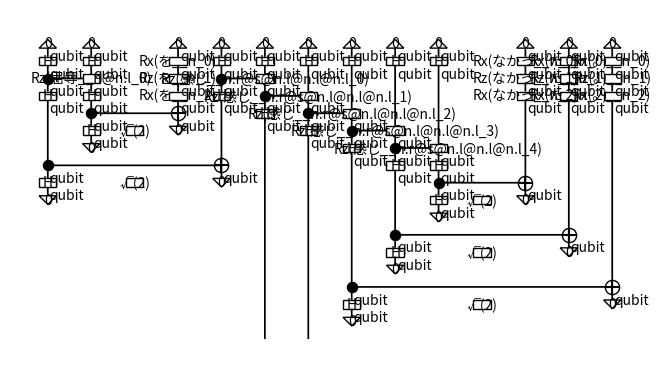

--- diagram 1 ---


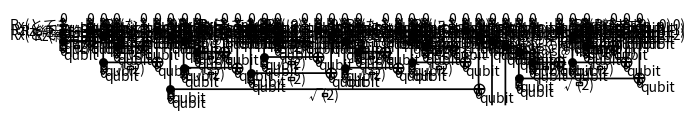

--- diagram 2 ---


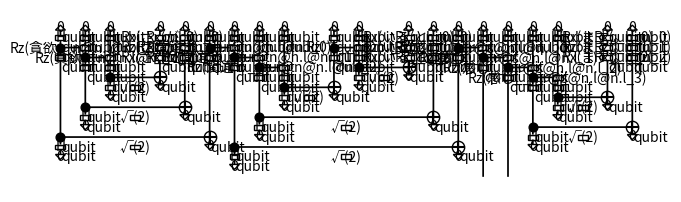

--- diagram 3 ---


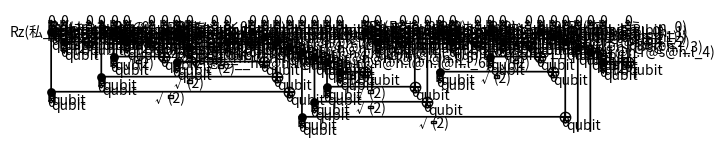

--- diagram 4 ---


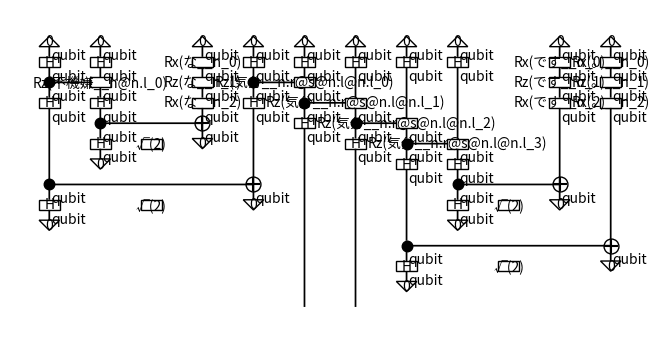

--- diagram 5 ---


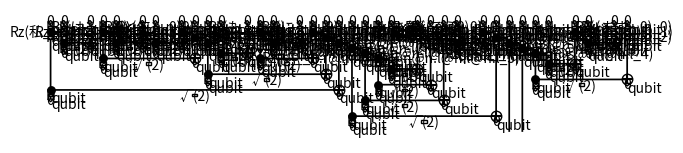

--- diagram 6 ---


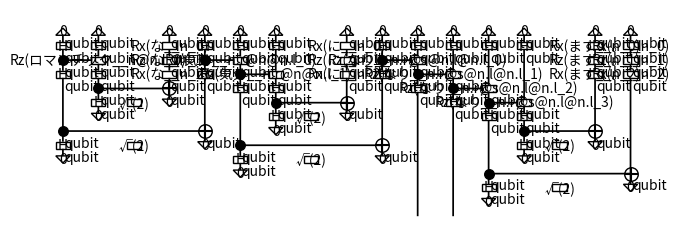

--- diagram 7 ---


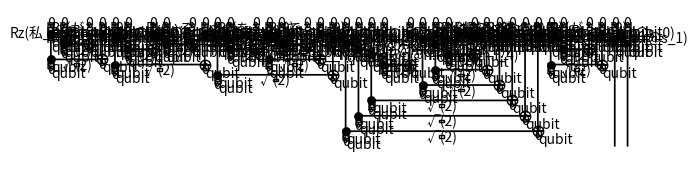

--- diagram 8 ---


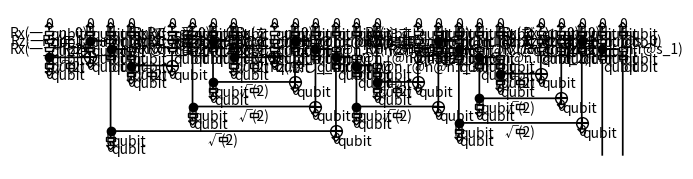

--- diagram 9 ---


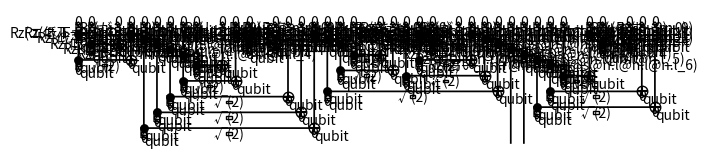

In [37]:
for i, c in enumerate(train_circuits[:10]):
    print(f"--- diagram {i} ---")
    draw(c)


In [38]:
print(len(train_circuits), len(train_labels))

12297 12297


In [39]:
def acc(y_hat, y):
    # y_hat: (B, 2, 2) → (B, 4)
    probs = np.abs(y_hat.reshape(len(y_hat), 4))**2
    probs = probs / probs.sum(axis=1, keepdims=True)

    return np.mean(
        np.argmax(probs, axis=1) == np.argmax(y, axis=1)
    )


In [40]:
# 量子回路シミュレーションをする計算モデルを構築
all_circuits = train_circuits + dev_circuits + test_circuits # モデル初期化時に全量子回路を提供するための準備
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

# 損失関数と予測精度の定義
ce = CELoss4()
acc = lambda y_hat, y: np.mean( np.argmax(y_hat, axis=1) == np.argmax(y, axis=1) )


In [41]:
# ハイパーパラメータ
BATCH_SIZE = 30
# LEARNING_RATE = 3e-2
EPOCHS = 1000
SEED = 0

# trainerの定義
trainer = QuantumTrainer(
    model,
    loss_function=ce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.1, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose='text',
    seed=SEED
)

train_dataset = Dataset(train_circuits, train_labels, batch_size=BATCH_SIZE)
val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

In [42]:
print("circuits:", len(train_circuits))
print("labels:", len(train_labels))

# もし circuits の中に None がある場合
print("None circuits:", sum(c is None for c in train_circuits))

# circuits と labels のサンプル
print(type(train_circuits[0]), train_labels[0])


circuits: 12297
labels: 12297
None circuits: 0
<class 'lambeq.backend.quantum.Diagram'> [[1. 0.]
 [0. 0.]]


In [ ]:
trainer.fit(train_dataset, val_dataset, log_interval=50)

In [ ]:
shapes = set()
for d in train_diagrams:
    shapes.add(np.array(d).shape)

print(shapes)


{(51,), (57,), (63,), (60,), (11,), (75,), (17,), (23,), (20,), (26,), (29,), (35,), (32,), (38,), (44,), (41,), (47,), (50,), (53,), (59,), (7,), (65,), (71,), (16,), (13,), (19,), (25,), (22,), (28,), (31,), (37,), (34,), (40,), (43,), (49,), (46,), (52,), (55,), (61,), (58,), (9,), (67,), (18,), (15,), (21,), (24,), (30,), (27,), (33,), (36,), (42,), (39,), (45,), (48,), (54,)}


In [ ]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))

train_acc = acc(model(train_circuits), np.array(train_labels))
test_acc = acc(model(test_circuits), np.array(test_labels))
print('Train accuracy:', train_acc)
print('Test accuracy:', test_acc)